In [1]:
# generate_workforce_dataset.py
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os, math

# Output path (change if you want)
out_path = './workforce_forecast_dataset.csv'
os.makedirs(os.path.dirname(out_path) or '.', exist_ok=True)

# Parameters
start = datetime(2023,1,1)
days = 180
hours = 24 * days
rng = [start + timedelta(hours=i) for i in range(hours)]
AHT_minutes = 6.0       # average handling time in minutes
occupancy = 0.85        # target occupancy used for staffing calc

# Build baseline seasonality (daily + weekly) + small upward trend + noise
base = []
for dt in rng:
    hour = dt.hour
    dow = dt.weekday()
    # daily shape: night low, morning rise, midday moderate, evening peak
    if 0 <= hour < 6:
        h_mul = 0.3
    elif 6 <= hour < 10:
        h_mul = 0.8
    elif 10 <= hour < 15:
        h_mul = 1.2
    elif 15 <= hour < 19:
        h_mul = 1.4
    elif 19 <= hour < 22:
        h_mul = 1.1
    else:
        h_mul = 0.6
    w_mul = 0.9 if dow >= 5 else 1.0
    base.append(h_mul * w_mul)
base = np.array(base)
trend = 1 + np.linspace(0, 0.03, hours)
np.random.seed(42)
noise = 1 + np.random.normal(0.0, 0.08, size=hours)

scale = 120  # baseline hourly volume scale
expected_volume = (base * scale * trend * noise).round().astype(int)
expected_volume[expected_volume < 0] = 0

# Simulate actual volume: mostly same as expected plus occasional surges/dips
actual_volume = expected_volume.copy()
for _ in range(10):
    i = np.random.randint(0, hours-6)
    actual_volume[i:i+6] = (actual_volume[i:i+6] * (1 + np.random.uniform(0.25,0.6))).round().astype(int)
for _ in range(8):
    i = np.random.randint(0, hours-4)
    actual_volume[i:i+4] = (actual_volume[i:i+4] * (1 - np.random.uniform(0.15,0.4))).round().astype(int)

# Required agents calc (simple capacity formula)
required_agents = np.ceil((actual_volume * (AHT_minutes / 60.0)) / occupancy).astype(int)
required_agents[required_agents < 1] = 1

# Scheduled staff (planned roster) — sometimes +/- around required
scheduled_staff = (required_agents + np.random.randint(-2, 3, size=hours)).astype(int)
scheduled_staff[scheduled_staff < 1] = 1

# Attendance / shrinkage
attendance_rate = np.clip(0.96 + np.random.normal(0, 0.02, size=hours), 0.85, 0.99)
available_staff = np.floor(scheduled_staff * attendance_rate).astype(int)
available_staff[available_staff < 0] = 0

# Handled per hour (approx)
handled = np.minimum(available_staff * (60 / AHT_minutes), actual_volume).astype(int)

# Backlog: simple cumulative logic when demand > handled
backlog = np.zeros(hours, dtype=int)
for idx in range(hours):
    if idx == 0:
        backlog[idx] = max(0, actual_volume[idx] - handled[idx])
    else:
        backlog[idx] = max(0, backlog[idx-1] + actual_volume[idx] - handled[idx])

# SLA proxy: fraction handled / volume (>=0.8 -> SLA met)
sla_ratio = np.divide(handled, actual_volume, out=np.ones_like(handled, dtype=float), where=actual_volume>0)
SLA_met = (sla_ratio >= 0.8).astype(int)

df = pd.DataFrame({
    'Timestamp': rng,
    'Date': [d.date() for d in rng],
    'Hour': [d.hour for d in rng],
    'DayOfWeek': [d.weekday() for d in rng],
    'ExpectedVolume': expected_volume,
    'ActualVolume': actual_volume,
    'AHT_minutes': AHT_minutes,
    'RequiredAgents': required_agents,
    'ScheduledStaff': scheduled_staff,
    'AttendanceRate': np.round(attendance_rate, 3),
    'AvailableStaff': available_staff,
    'Handled': handled,
    'Backlog': backlog,
    'SLA_Met': SLA_met
})

df.to_csv(out_path, index=False)
print(f"Saved dataset to: {out_path}")
print("Rows:", len(df))
print(df.head().to_string(index=False))


Saved dataset to: ./workforce_forecast_dataset.csv
Rows: 4320
          Timestamp       Date  Hour  DayOfWeek  ExpectedVolume  ActualVolume  AHT_minutes  RequiredAgents  ScheduledStaff  AttendanceRate  AvailableStaff  Handled  Backlog  SLA_Met
2023-01-01 00:00:00 2023-01-01     0          6              34            34          6.0               5               7           0.966               6       34        0        1
2023-01-01 01:00:00 2023-01-01     1          6              32            32          6.0               4               6           0.937               5       32        0        1
2023-01-01 02:00:00 2023-01-01     2          6              34            34          6.0               5               4           0.937               3       30        4        1
2023-01-01 03:00:00 2023-01-01     3          6              36            36          6.0               5               3           0.966               2       20       20        0
2023-01-01 04:00:00 2023-01-

In [3]:
# simple_prophet_forecast.py
import pandas as pd
from prophet import Prophet

df = pd.read_csv('workforce_forecast_dataset.csv', parse_dates=['Timestamp'])
# aggregate hourly -> daily
daily = df.groupby(df['Date']).agg({'ActualVolume':'sum'}).reset_index()
daily.columns = ['ds','y']  # prophet expects ds,y
m = Prophet(daily_seasonality=True, yearly_seasonality=False)
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.fit(daily)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()


16:55:06 - cmdstanpy - INFO - Chain [1] start processing
16:55:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
205,2023-07-25,2681.317308,2551.720492,2827.153600
206,2023-07-26,2589.915100,2447.777125,2714.575248
207,2023-07-27,2622.403110,2484.432995,2761.585748
208,2023-07-28,2639.688216,2497.014347,2775.561438
209,2023-07-29,2413.861988,2281.722131,2542.878750


Daily dataset preview:
           ds     y
0  2023-01-01  2221
1  2023-01-02  2475
2  2023-01-03  2865
3  2023-01-04  2520
4  2023-01-05  2559


16:58:18 - cmdstanpy - INFO - Chain [1] start processing
16:58:18 - cmdstanpy - INFO - Chain [1] done processing



Forecast saved as forecast_output_30days.csv
            ds         yhat   yhat_lower   yhat_upper
205 2023-07-25  2682.221056  2547.234567  2817.172031
206 2023-07-26  2590.872283  2452.500234  2730.922084
207 2023-07-27  2623.409188  2487.772152  2755.151580
208 2023-07-28  2640.606616  2500.654707  2772.541659
209 2023-07-29  2414.802652  2276.894120  2561.101958


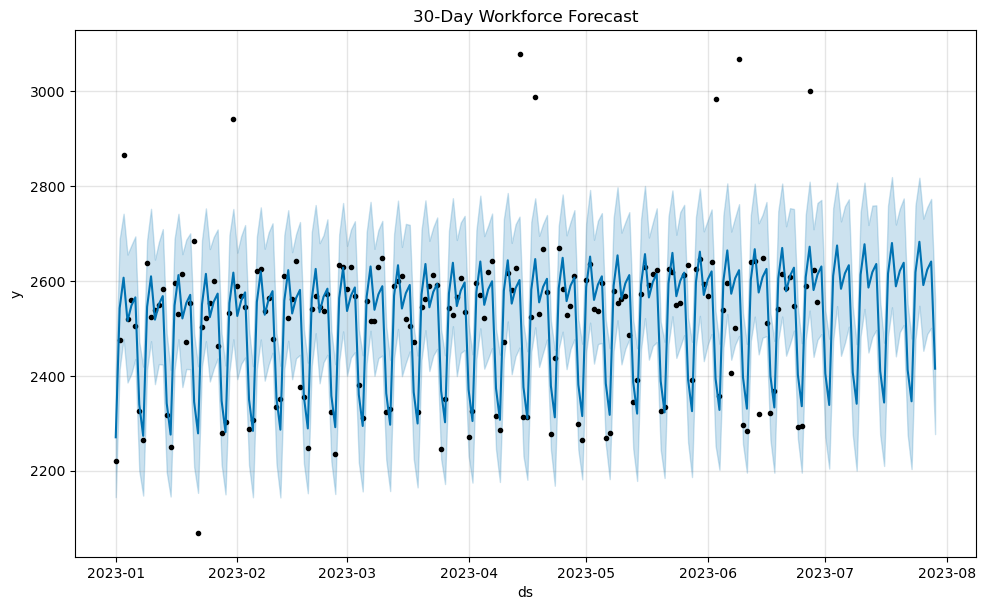

In [5]:
# ============================================
# WORKFORCE FORECASTING MODEL (PROPHET)
# ============================================

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("workforce_forecast_dataset.csv", parse_dates=['Timestamp'])

# 2. Aggregate hourly -> daily total volume
daily = df.groupby(df['Timestamp'].dt.date)['ActualVolume'].sum().reset_index()
daily.columns = ['ds', 'y']   # Prophet requires 'ds' and 'y'

print("Daily dataset preview:")
print(daily.head())

# 3. Build Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

model.fit(daily)

# 4. Future dataframe for next 30 days
future = model.make_future_dataframe(periods=30)

# 5. Predict
forecast = model.predict(future)

# 6. Save forecast for Power BI
forecast_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_out.to_csv("forecast_output_30days.csv", index=False)

print("\nForecast saved as forecast_output_30days.csv")
print(forecast_out.tail())

# 7. Plot (optional)
model.plot(forecast)
plt.title("30-Day Workforce Forecast")
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Load forecast (already created)
forecast = pd.read_csv("forecast_output_30days.csv")

# Parameters
AHT = 6.0         # minutes
occupancy = 0.85

# 1. Forecasted daily volume
forecast['ForecastVolume'] = forecast['yhat'].round().astype(int)

# 2. Required agents
forecast['RequiredAgents'] = np.ceil(
    (forecast['ForecastVolume'] * (AHT/60)) / occupancy
).astype(int)

# 3. Scheduled Staff (placeholder)
# Note: You can update this later with real values or a scenario slider in Power BI
forecast['ScheduledStaff'] = forecast['RequiredAgents'] - 2
forecast.loc[forecast['ScheduledStaff'] < 1, 'ScheduledStaff'] = 1

# 4. Staffing Gap
forecast['StaffingGap'] = forecast['RequiredAgents'] - forecast['ScheduledStaff']

# 5. SLA Risk
forecast['SLA_Risk'] = np.where(forecast['StaffingGap'] > 0, "High", "Low")

# Clean output
final_forecast = forecast[['ds','ForecastVolume','RequiredAgents','ScheduledStaff','StaffingGap','SLA_Risk']]

# Save to CSV
final_forecast.to_csv("Workforce_Forecast_Final.csv", index=False)

print("Final Workforce Forecast saved as: Workforce_Forecast_Final.csv")
print(final_forecast.head(15))


Final Workforce Forecast saved as: Workforce_Forecast_Final.csv
            ds  ForecastVolume  RequiredAgents  ScheduledStaff  StaffingGap  \
0   2023-01-01            2270             268             266            2   
1   2023-01-02            2542             300             298            2   
2   2023-01-03            2607             307             305            2   
3   2023-01-04            2515             296             294            2   
4   2023-01-05            2548             300             298            2   
5   2023-01-06            2565             302             300            2   
6   2023-01-07            2339             276             274            2   
7   2023-01-08            2273             268             266            2   
8   2023-01-09            2545             300             298            2   
9   2023-01-10            2609             307             305            2   
10  2023-01-11            2518             297             295     